<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/POLLARDSTOWN_s_3_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/Pollardstown.zip" -d "/content/dataset"

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
S_RGB_PATH = '/content/dataset/Pollardstown/pollardstown_ortho.tif'
S_NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif'
SHP_PATH = '/content/dataset/Pollardstown/Pollardstown_clappied.shp'

LABEL_COL = 'Id'
NAME_COL = 'PRIMARY_FO'

In [3]:
gdf = gpd.read_file(SHP_PATH)

In [4]:
gdf = gpd.read_file(SHP_PATH)
fossitt_merger = {
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub', 'GS4/WS1': 'Woodland_Scrub', 'Scrub_Woodland': 'Woodland_Scrub',
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland', 'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland', 'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)
gdf['class_id'] = gdf['merged_name'].astype('category').cat.codes
class_map = dict(enumerate(gdf['merged_name'].astype('category').cat.categories))

In [7]:
from rasterio.mask import mask
all_pixels = []
all_labels = []
MAX_SAMPLES_PER_POLY = 1000

with rasterio.open(S_RGB_PATH) as src:
    gdf = gdf.to_crs(src.crs)

    for idx, row in gdf.iterrows():
        try:
            # Mask the raster to the polygon
            out_image, _ = mask(src, [row.geometry], crop=True)

            # (Bands, H, W) -> (Pixels, Bands)
            n_bands = out_image.shape[0]
            flattened = out_image.reshape(n_bands, -1).T

            # Remove NoData (0) pixels
            valid_indices = np.any(flattened != 0, axis=1)
            pixels = flattened[valid_indices]

            if len(pixels) > 0:
                # SUB-SAMPLING: If polygon is huge, only take a random subset
                if len(pixels) > MAX_SAMPLES_PER_POLY:
                    idx_random = np.random.choice(len(pixels), MAX_SAMPLES_PER_POLY, replace=False)
                    pixels = pixels[idx_random]

                all_pixels.append(pixels)
                all_labels.extend([row['merged_name']] * len(pixels))
        except Exception as e:
            continue

# Stack into final arrays
X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Total training samples: {len(X)}")

Total training samples: 30028


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [11]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

print("Training the Random Forest model...")
rf.fit(X_train, y_train)

Training the Random Forest model...


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [10]:
print(classification_report(y_test, rf.predict(X_test)))

                  precision    recall  f1-score   support

   Grassland_Wet       0.56      0.43      0.48      1800
Wetland_Peatland       0.80      0.88      0.84      5409
  Woodland_Scrub       0.58      0.53      0.55      1800

        accuracy                           0.72      9009
       macro avg       0.65      0.61      0.63      9009
    weighted avg       0.71      0.72      0.71      9009



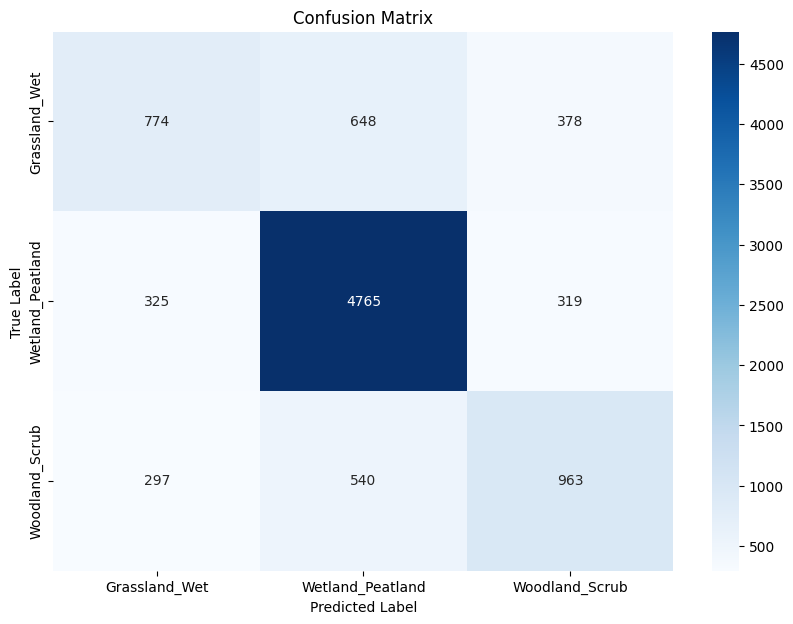

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

texture addition

In [5]:
from scipy import ndimage

def add_texture_layer(data):
    """
    Calculates texture (edges) using the NDVI band (last band).
    Returns data with an additional 5th band.
    """
    # Use the NDVI band for texture
    ndvi_band = data[-1].astype('float32')

    # Calculate Sobel edges
    sx = ndimage.sobel(ndvi_band, axis=0)
    sy = ndimage.sobel(ndvi_band, axis=1)
    sobel = np.hypot(sx, sy)

    # Normalize sobel to 0-255 or similar scale if needed, or keep as float
    return np.concatenate([data, sobel[np.newaxis, :]], axis=0)

In [6]:
gdf = gpd.read_file(SHP_PATH)
fossitt_merger = {
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub', 'GS4/WS1': 'Woodland_Scrub', 'Scrub_Woodland': 'Woodland_Scrub',
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland', 'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland', 'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [11]:
from rasterio.mask import mask
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as src:
    # 1. Check if CRS matches
    gdf = gdf.to_crs(src.crs)
    print(f"Raster CRS: {src.crs}")
    print(f"Vector CRS: {gdf.crs}")

    for idx, row in gdf.iterrows():
        try:
            # 2. Extract the data
            out_img, _ = mask(src, [row.geometry], crop=True)

            # 3. Add Texture
            img_with_tex = add_texture_layer(out_img)

            n_bands = img_with_tex.shape[0]
            flat = img_with_tex.reshape(n_bands, -1).T

            # Filter non-zero pixels (assuming 0 is NoData)
            valid = np.any(flat[:, :3] != 0, axis=1)
            pixels = flat[valid]

            if len(pixels) > 0:
                if len(pixels) > 500:
                    pixels = pixels[np.random.choice(len(pixels), 500, replace=False)]

                all_pixels.append(pixels)
                all_labels.extend([row['merged_name']] * len(pixels))
            else:
                print(f"Polygon {idx} returned 0 valid pixels.")

        except Exception as e:
            print(f"Error on polygon {idx}: {e}")

# Check if we actually got data before stacking
if len(all_pixels) > 0:
    X = np.vstack(all_pixels)
    y = np.array(all_labels)
    print(f"Successfully extracted {len(X)} samples.")
else:
    print("CRITICAL: No data was extracted. Check if your shapefile overlaps with the image!")

Raster CRS: EPSG:2157
Vector CRS: PROJCS["IRENET95 / Irish Transverse Mercator",GEOGCS["IRENET95",DATUM["IRENET95",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6173"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4173"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",53.5],PARAMETER["central_meridian",-8],PARAMETER["scale_factor",0.99982],PARAMETER["false_easting",600000],PARAMETER["false_northing",750000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2157"]]
Polygon 0 returned 0 valid pixels.
Polygon 2 returned 0 valid pixels.
Polygon 3 returned 0 valid pixels.
Polygon 4 returned 0 valid pixels.
Polygon 5 returned 0 valid pixels.
Polygon 36 returned 0 valid pixels.
Successfully extracted 15028 samples.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=250,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

print("Training Random Forest...")
rf.fit(X_train, y_train)
print("\nAccuracy Report:")
print(classification_report(y_test, rf.predict(X_test)))

Training Random Forest...

Accuracy Report:
                  precision    recall  f1-score   support

   Grassland_Wet       0.53      0.43      0.47       900
Wetland_Peatland       0.80      0.87      0.83      2709
  Woodland_Scrub       0.57      0.51      0.54       900

        accuracy                           0.71      4509
       macro avg       0.63      0.60      0.61      4509
    weighted avg       0.70      0.71      0.70      4509



bands indices

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from scipy import ndimage, stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask

In [6]:
fossitt_merger = {
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland'
}

In [7]:
gdf = gpd.read_file(SHP_PATH)
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)
gdf = gdf[gdf.geometry.notnull()]

In [8]:
max_possible_samples = len(gdf) * 500
print(f"Allocating space for up to {max_possible_samples} samples...")

Allocating space for up to 18500 samples...


In [9]:
def add_rgb_features(data):
    """
    Calculates 4 additional bands from RGB: VARI, GLI, TGI, and Texture.
    Assumes Band Order: 0:Red, 1:Green, 2:Blue
    """
    data_f = data.astype('float32')
    R, G, B = data_f[0], data_f[1], data_f[2]

    # VARI - Very stable for RGB vegetation detection
    vari = (G - R) / (G + R - B + 1e-5)

    # GLI - Green Leaf Index
    gli = (2*G - R - B) / (2*G + R + B + 1e-5)

    # TGI - Triangular Greenness Index
    tgi = G - (0.39 * R) - (0.61 * B)

    # Texture (Sobel on the Green band - usually has best contrast for habitats)
    sx = ndimage.sobel(G, axis=0)
    sy = ndimage.sobel(G, axis=1)
    sobel = np.hypot(sx, sy)

    # Stack original 3 bands + 4 new features = 7 bands total
    stacked = np.concatenate([
        data,
        vari[np.newaxis, :],
        gli[np.newaxis, :],
        tgi[np.newaxis, :],
        sobel[np.newaxis, :]
    ], axis=0)

    return stacked

In [10]:
# @title
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point

def get_random_points_in_poly(poly, num_points):
    """Generates random points strictly within a polygon."""
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if random_point.within(poly):
            points.append(random_point)
    return points

all_pixels = []
all_labels = []

print("Starting Point Sampling (Memory-Safe)...")

with rasterio.open(S_RGB_PATH) as src:
    gdf = gpd.read_file(SHP_PATH).to_crs(src.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    # Process each polygon
    for idx, row in gdf.iterrows():
        try:
            # 1. Generate 500 random points inside the polygon
            pts = get_random_points_in_poly(row.geometry, 500)

            # 2. Get the XY coordinates for these points
            coords = [(p.x, p.y) for p in pts]

            # 3. Sample the raster at these specific points
            # src.sample returns a generator of pixel values
            samples = list(src.sample(coords))
            samples = np.array(samples).astype('float32')

            # 4. On-the-fly feature engineering (Indices + Texture)
            # Since we only have points, we can't do local texture (Sobel) here.
            # To compensate, we will only calculate the RGB Indices (VARI, GLI, TGI).

            R, G, B = samples[:, 0], samples[:, 1], samples[:, 2]
            vari = (G - R) / (G + R - B + 1e-5)
            gli = (2*G - R - B) / (2*G + R + B + 1e-5)
            tgi = G - (0.39 * R) - (0.61 * B)

            # Stack: [R, G, B, VARI, GLI, TGI] -> 6 features
            combined = np.column_stack([samples, vari, gli, tgi])

            # Filter out any background/zero hits
            valid = np.any(combined[:, :3] > 0, axis=1)

            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))

        except Exception as e:
            continue

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Success! Extracted {X.shape[0]} samples using Point Sampling.")

Starting Point Sampling (Memory-Safe)...


KeyboardInterrupt: 

In [11]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import time

# --- CONFIG ---
MAX_POINTS = 300  # Reduced slightly to speed up significantly
all_pixels = []
all_labels = []

with rasterio.open(S_RGB_PATH) as src:
    gdf = gpd.read_file(SHP_PATH).to_crs(src.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    start_time = time.time()
    print(f"Starting extraction on {len(gdf)} polygons...")

    for idx, row in gdf.iterrows():
        # Status update every 20 polygons
        if idx % 20 == 0:
            elapsed = round(time.time() - start_time, 1)
            print(f"Polygon {idx}/{len(gdf)}... Time elapsed: {elapsed}s")

        try:
            poly = row.geometry
            if poly.is_empty or not poly.is_valid:
                continue

            # 1. FAST POINT GENERATION
            points = []
            min_x, min_y, max_x, max_y = poly.bounds

            # Using a fixed number of attempts to keep it fast
            for _ in range(1000):
                rand_x = np.random.uniform(min_x, max_x)
                rand_y = np.random.uniform(min_y, max_y)
                p = Point(rand_x, rand_y)
                if p.within(poly):
                    points.append((rand_x, rand_y))
                if len(points) >= MAX_POINTS:
                    break

            if not points:
                continue

            # 2. SAMPLING (Vectorized)
            samples = np.array(list(src.sample(points))).astype('float32')

            # 3. INDICES (VARI, GLI, TGI)
            # Assuming Band Order: 0:Red, 1:Green, 2:Blue
            R, G, B = samples[:, 0], samples[:, 1], samples[:, 2]

            eps = 1e-5
            vari = (G - R) / (G + R - B + eps)
            gli = (2*G - R - B) / (2*G + R + B + eps)
            tgi = G - (0.39 * R) - (0.61 * B)

            # Stack: [R, G, B, VARI, GLI, TGI]
            combined = np.column_stack([samples, vari, gli, tgi])

            # Filter zero pixels
            valid = np.any(samples > 0, axis=1)

            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))

        except Exception:
            continue

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"--- FINISHED in {round(time.time() - start_time, 2)} seconds ---")
print(f"Final Dataset: {X.shape}")

Starting extraction on 37 polygons...
Polygon 0/37... Time elapsed: 0.0s
Polygon 20/37... Time elapsed: 11.2s
--- FINISHED in 18.94 seconds ---
Final Dataset: (8408, 6)


In [12]:
print(f"Successfully extracted {len(X)} samples.")

Successfully extracted 8408 samples.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print(classification_report(y_test, rf.predict(X_test)))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Initialize and Train
# We use balanced class weights to ensure small habitats aren't ignored
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

print("Training Random Forest on 6 features...")
rf.fit(X_train, y_train)

# 3. Evaluate
y_pred = rf.predict(X_test)
print("\n--- Validation Report ---")
print(classification_report(y_test, y_pred))

# 4. Map the numeric IDs for the TIF output
unique_classes = sorted(list(np.unique(y)))
class_to_id = {name: i for i, name in enumerate(unique_classes)}
print(f"Legend Mapping: {class_to_id}")

Training Random Forest on 6 features...

--- Validation Report ---
                  precision    recall  f1-score   support

         FS1/PF1       0.10      0.04      0.06       180
         GS4/FS1       0.00      0.00      0.00        62
         GS4/WS1       0.09      0.03      0.05        90
   Grassland_Wet       0.50      0.54      0.52       540
         WN6/FS1       0.07      0.02      0.03        90
Wetland_Peatland       0.70      0.82      0.76      1294
  Woodland_Scrub       0.42      0.42      0.42       267

        accuracy                           0.59      2523
       macro avg       0.27      0.27      0.26      2523
    weighted avg       0.52      0.59      0.55      2523

Legend Mapping: {np.str_('FS1/PF1'): 0, np.str_('GS4/FS1'): 1, np.str_('GS4/WS1'): 2, np.str_('Grassland_Wet'): 3, np.str_('WN6/FS1'): 4, np.str_('Wetland_Peatland'): 5, np.str_('Woodland_Scrub'): 6}


In [14]:
# 1. Define a robust cleaning map
clean_map = {
    'FS1/PF1': 'Wetland_Peatland',
    'GS4/FS1': 'Wetland_Peatland', # Usually more peat-dominant in spectral signature
    'GS4/WS1': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub',
    'Grassland_Wet': 'Grassland_Wet',
    'Wetland_Peatland': 'Wetland_Peatland',
    'Woodland_Scrub': 'Woodland_Scrub'
}

# 2. Apply it to your existing 'y' array
y_cleaned = np.array([clean_map.get(label, label) for label in y])

# 3. Re-split and Re-train
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cleaned, test_size=0.3, stratify=y_cleaned, random_state=42
)

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Cleaned Validation Report ---")
print(classification_report(y_test, rf.predict(X_test)))


--- Cleaned Validation Report ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.52      0.46      0.49       540
Wetland_Peatland       0.81      0.86      0.84      1536
  Woodland_Scrub       0.53      0.50      0.52       447

        accuracy                           0.71      2523
       macro avg       0.62      0.61      0.61      2523
    weighted avg       0.70      0.71      0.71      2523



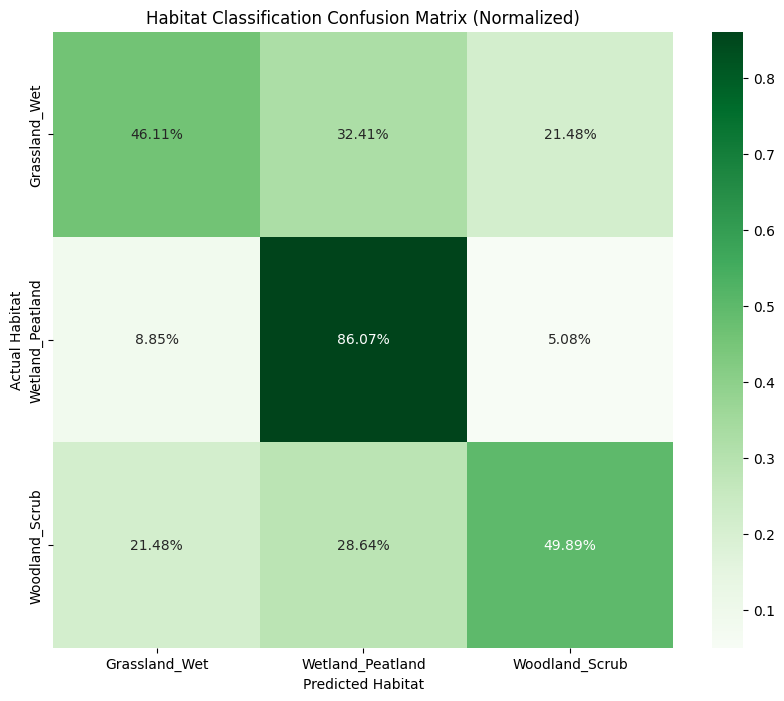

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Create the matrix
cm = confusion_matrix(y_test, rf.predict(X_test), labels=unique_classes)

# 2. Convert to percentages for easier reading
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=unique_classes, yticklabels=unique_classes)

plt.title('Habitat Classification Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()